# Dataset Exploration and Shifts (dSprites)

This notebook explore the dSprites original and shifted version. We visualise and verify correctness of various shift.  

**Details**: The dSprite dataset consists of 2D shapes procedurally generated from 6 ground truth independent latent factors: *color (1 possible value), shape (3 possible values), scale (6), rotation (40), x (32) and y (32) positions of a sprite*. All possible combinations of these latents are present exactly once generating 737,280 total images shown in the dataset.

**Notes**: see [dSprites](https://github.com/deepmind/dsprites-dataset) for more details.

In [6]:
import numpy as np
import torch
import random
from scipy.stats import ks_2samp, binom_test, chisquare, chi2_contingency, anderson_ksamp
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from tensorflow.python import keras
from tensorflow.python.keras import layers

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Run utility functions
%run drive/MyDrive/Colab\ Notebooks/MPhil\ Project/Utilities.ipynb

## Loading dSprites

In this section, we will load and visualise the dSprite datasets.

In [8]:
# Load dataset, split into train test
path = 'drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
x_train, x_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, train_size=0.85, class_index=1)

# Split training into validation set as well
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]
c_train, c_valid = c_train[:50000], c_train[50000:]

Training samples: 85000
Testing samples: 15000


In [9]:
# Print class proportion
print("Train")
print(pd.DataFrame(y_train).value_counts())
print("****\n")

print("Validation")
print(pd.DataFrame(y_valid).value_counts())
print("****\n")

print("Test")
print(pd.DataFrame(y_test).value_counts())
print("****\n")

Train
1    16777
0    16706
2    16517
dtype: int64
****

Validation
1    11921
2    11550
0    11529
dtype: int64
****

Test
2    5040
0    5035
1    4925
dtype: int64
****



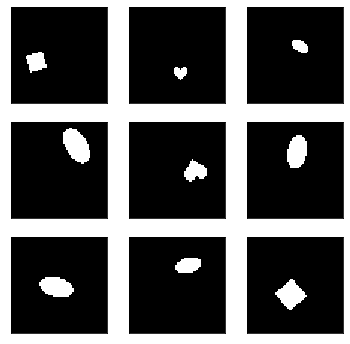

In [10]:
# Randomly sample some latents (from the dataset)
latents_sampled = sample_latent(size=49)

# Select images
imgs_sampled = x_train[:10].reshape(-1, 64, 64)

# Show images
show_images_grid(imgs_sampled, num_images=9)

## Shifts Applicator

In this section, we will apply various shifts to the data and visualise it.

In [11]:
# Reshape
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = x_train.shape[1:] # constant hold the image original shape
x_train_flatten = deepcopy(x_train.reshape(x_train.shape[0], -1))
x_valid_flatten = deepcopy(x_valid.reshape(x_valid.shape[0], -1))
x_test_flatten = deepcopy(x_test.reshape(x_test.shape[0], -1))

### Gaussian Noise

We apply gaussian noise to the image and observe the result.

#### Large Gaussian Shift

In [12]:
## Large gaussian shift (with delta = 1/ applied to full dataset)
shift = "large_gn_shift_1.0"
x_gaussian, y_gaussian = apply_gaussian_shift(deepcopy(x_test_flatten), y_test, shift) 

Large GN shift


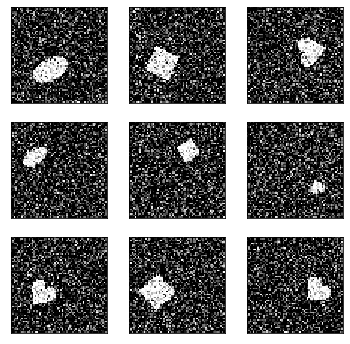

In [13]:
# Plot example of images after applying large gaussian shift to them
show_images_grid(x_gaussian.reshape([-1, 64, 64]), num_images=9)

#### Medium Gaussian Shift

In [14]:
## Medium gaussian shift (with delta = 1)
shift = "medium_gn_shift_1.0"
x_gaussian, y_gaussian = apply_gaussian_shift(deepcopy(x_test_flatten), y_test, shift) 

Medium GN Shift


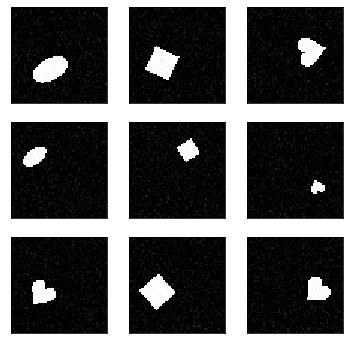

In [15]:
# Plot example of images after applying medium gaussian shift to them
show_images_grid(x_gaussian.reshape([-1, 64, 64]), num_images=9)

The noise is barely noticeable by human eye (but upon inspecting the array, the values have changed.

#### Small Gaussian Shift

In [16]:
## Medium gaussian shift (with delta = 1)
shift = "small_gn_shift_1.0"
x_gaussian, y_gaussian = apply_gaussian_shift(deepcopy(x_test_flatten), y_test, shift) 

Small GN Shift


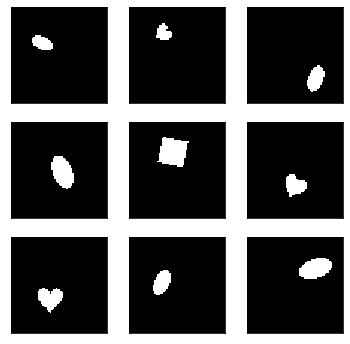

In [17]:
# Plot example of images after applying small gaussian shift to them
show_images_grid(x_test_flatten.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)

The noise is barely noticeable by human eye (but upon inspecting the array, the values have changed.

### Knockout shift

We apply the knockout shift, which create class imbalance.

In [18]:
## Large gaussian shift (with delta = 1/ applied to full dataset)
shift = "ko_shift_1.0"
x_gaussian, y_gaussian = apply_ko_shift(deepcopy(x_train_flatten), y_train, shift, cl=1) 

Large knockout shift


In [19]:
pd.DataFrame(y_gaussian).value_counts()

0    16706
2    16517
dtype: int64

Class 1 is removed altogether by the knockout shift creating extreme class imbalance.

### Image Shift

we apply various image shift, including translation, rotation, zoom, horizontal flip, vertical flip.

In [20]:
## Large image shift (with delta = 1/ applied to full dataset)
shift = "large_img_shift_1.0"
x_img, y_img = apply_img_shift(deepcopy(x_train_flatten), y_train, ORIGINAL_SHAPE, "large", 1.0)

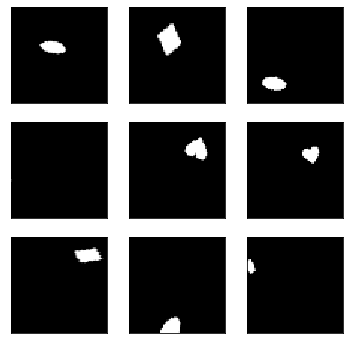

In [21]:
# Plot example of images after applying large image shift to them
show_images_grid(x_img.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)

#### Isolated Shift

**Translation**

In [22]:
## Large image shift (with delta = 1/ applied to full dataset)
shift = "large_img_shift_1.0" # (translation)
x_img, y_img = apply_img_shift(deepcopy(x_train_flatten), y_train, ORIGINAL_SHAPE, "large", 1.0, ["width_shift", "height_shift"])

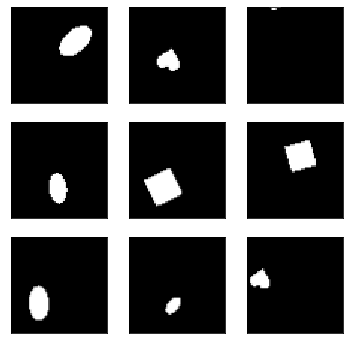

In [23]:
# Plot example of images after applying large image shift to them
show_images_grid(x_img.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)

**Shear**

In [36]:
## Large image shift (with delta = 1/ applied to full dataset)
shift = "large_img_shift_1.0" # (shear)
x_img, y_img = apply_img_shift(deepcopy(x_train_flatten), y_train, ORIGINAL_SHAPE, "large", 1.0, ["shear", "flip", "zoom"])

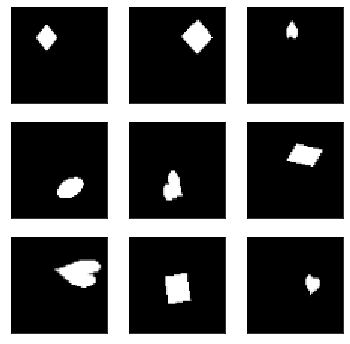

In [27]:
# Plot example of images after applying large image shift to them
show_images_grid(x_img.reshape([-1, 64, 64])[np.random.randint(0, 2000, 50)], num_images=9)